In [27]:
import tensorflow.keras
tensorflow.keras.__version__


'2.1.6-tf'

## Практика №4. Задача прогнозирования температуры

До сих пор мы рассматривали единственную разновидность последовательных
данных — текстовые данные, такие как в наборах данных IMDB и Reuters. Однако
последовательные данные можно найти во многих других областях, не только
в обработке естественного языка. Во всех примерах в этом разделе будут использоваться временные последовательности данных о погоде, записанных на гидрометеорологической станции в институте биогеохимии Макса Планка в Йене (Jena),
Германия https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

В этот набор данных включены замеры 14 разных характеристик (таких, как температура, атмосферное давление, влажность, направление ветра и т. д.), выполнявшиеся каждые 10 минут в течение нескольких лет. Вообще сбор данных был
начат в 2003-м, но в этот пример включены только данные за 2009–2016 годы. Этот
набор данных идеально подходит для изучения принципов работы с числовыми
временными рядами. Мы воспользуемся ими для создания модели, принимающей
на входе некоторые данные о погоде в ближайшем прошлом (за несколько дней)
и прогнозирующей температуру воздуха на ближайшие 24 часа в будущем.


Посмотрим, что у нас имеется.

In [2]:
import os

data_dir = '/data/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


Теперь преобразуем все 420 551 строку с данными в массив Numpy.

In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

Для примера построим график изменения температуры (в градусах
Цельсия). На этом графике ясно виден годовой цикл изменения температуры.

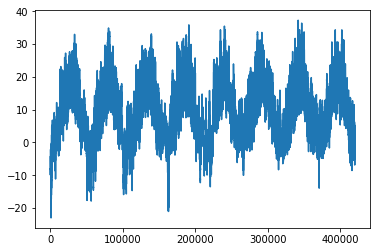

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()


Вот более короткий график изменения температуры — за первые 10 дней. Так как данные записываются каждые 10 минут, за сутки накапливается 144 замера.


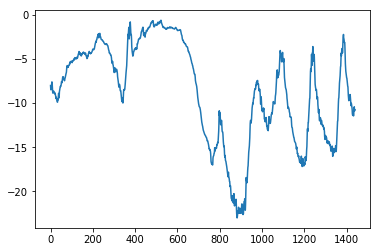

In [5]:
plt.plot(range(1440), temp[:1440])
plt.show()


На этом графике можно видеть суточный цикл изменения температуры, который
особенно четко наблюдается на отрезке, соответствующем последним четырем
дням. Также отметьте, что этот 10-дневный отрезок соответствует довольно холодному зимнему месяцу.
Если бы мы предсказывали среднюю температуру на следующий месяц по данным
за несколько предыдущих месяцев, эта не составило бы большого труда благодаря
устойчивой периодичности в масштабах года. Однако изменение температуры
в масштабе нескольких дней выглядит более хаотичным. Можно ли с высокой надежностью предсказать временную последовательность в масштабе суток? Давайте
посмотрим.


## Подготовка данных


Вот точная формулировка задачи: по lookback интервалам (один интервал равен
10 минутам) за прошлый период, из которых отобраны образцы через каждые step
интервалов, предсказать температуру на следующие delay интервалов. Мы будем
использовать следующие значения параметров:
* lookback = 720 — количество наблюдений за предыдущие 5 дней;
* step = 6 — шаг отбора образцов из наблюдений, то есть один образец за каждый час;
* delay = 144 — целью являются следующие 24 часа в будущем.
Прежде всего нам понадобится:
* Преобразовать данные в формат, понятный нейронной сети. Это легко: данные
уже представлены в числовом виде, поэтому нам не придется как-то векторизовать их. Однако все временные последовательности в данных имеют разный масштаб (например, температура обычно находится в диапазоне между –20
и +30, а атмосферное давление, измеряемое в миллибарах, изменяется около
значения 1000). Мы должны нормализовать временные последовательности
независимо друг от друга, чтобы все они состояли из небольших по величине
значений примерно одинакового масштаба.
* Написать на Python генератор, который принимает текущий массив данных
и возвращает пакеты данных, представляющие собой недавнее прошлое, а также
целевую температуру в будущем. Поскольку образцы в наборе данных излишне
избыточны (образцы N и N + 1 будут иметь много общего), было бы расточительством явно выделять и использовать каждый образец. Вместо этого мы будем генерировать образцы на лету, используя исходные данные.

В процессе обработки данных мы будем вычитать среднее для каждой временной
последовательности и делить на стандартное отклонение. Для обучения мы используем первые 200 000 замеров, поэтому среднее и стандартное отклонение должны
вычисляться только по этой выборке.


In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

В листинге ниже показана нужная нам функция-генератор данных. Она возвращает
кортеж (образцы, цели), где образцы — это один пакет входных данных, а цели —
соответствующий массив целевых температур. Функция принимает следующие
аргументы:
* data — исходный массив вещественных чисел, нормализованных кодом в листинге выше;
* lookback — количество интервалов в прошлом от заданного момента, за которое
отбираются входные данные;
* delay — количество интервалов в будущем от заданного момента, за которое
отбираются целевые данные;
* min_index и max_index — индексы в массиве data, ограничивающие область для
извлечения данных; это помогает оставить в неприкосновенности сегменты
проверочных и контрольных данных;
* shuffle — флаг, определяющий порядок извлечения образцов: с перемешива-
нием или в хронологическом порядке;
* batch_size — количество образцов в пакете;
* step — период в интервалах, из которого извлекается один образец; мы установим его равным 6, чтобы получить по одному образцу за каждый час.


In [7]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Теперь используем абстрактную функцию-генератор для создания трех других
функций-генераторов: для получения обучающих, проверочных и контрольных
данных. Все они будут отбирать образцы из разных временных сегментов оригинальных данных: обучающие данные будут извлекаться из первых 200 000 интервалов, проверочные — из следующих 100 000, а контрольные — из остальных.


In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## "Наивное" решение без привлечения машинного обучения
Прежде чем начать использовать черные ящики моделей глубокого обучения для
решения задачи прогнозирования температуры, опробуем более простой и очевидный подход. Он поможет провести базовую линию, которую мы должны будем превзойти, чтобы доказать преимущество более сложных моделей машинного
обучения. Такие очевидные базовые решения могут использоваться, когда вы подступаетесь к новой задаче, не имеющей (пока) известного решения. Классическим примером могут служить несбалансированные задачи классификации, когда не-
которые классы могут быть намного более распространены, чем другие. Если набор данных содержит 90 % экземпляров класса «А» и 10 % экземпляров класса «Б», тогда очевидным решением задачи классификации является неизменный выбор
класса «А» для предсказания классов новых образцов. Такой классификатор будет иметь общую точность 90 %, и, соответственно, любое решение на основе машинного обучения должно превзойти эти 90 %, чтобы доказать свою полезность. Иногда такие элементарные базовые решения на удивление трудно превзойти.
В данном случае временные последовательности можно с полной уверенностью считать монотонными (температура завтра, вероятно, будет близка к сегодняшней), а также подчиняющимися суточной периодичности. То есть разумным базовым
решением предсказания температуры через 24 часа является текущая температура.
Давайте оценим этот подход, использовав метрику средней абсолютной ошибки (Mean Absolute Error, MAE):
`np.mean(np.abs(preds - targets))`



Вот цикл оценки.

In [10]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


Этот цикл вернул оценку MAE, равную 0,29. Так как значения температуры нормализованы и теперь имеют среднее значение 0 и стандартное отклонение 1, данное число нельзя интерпретировать непосредственно. Средняя абсолютная ошибка в данном случае соответствует 0,29 × temperature_std градусам Цельсия: 2,57 °C.


## Базовое решение c привлечением машинного обучения

Перед попыткой создать такую сложную и затратную (в вычислительном смысле)
модель, как рекуррентная нейронная сеть, помимо базового решения без привлечения машинного обучения также полезно попробовать найти простые и незатратные модели машинного обучения (например, неглубокую полносвязную сеть). Это
лучший способ убедиться, что любые усложнения, направленные на решение задачи, оправданны и действительно дают преимущества.
В следующем листинге демонстрируется полносвязная модель, которая сначала
снижает размерность данных, а затем пропускает их через два слоя Dense. Обратите внимание на отсутствие функции активации в последнем слое Dense, что характерно для задачи регрессии. В роли оценки потерь используется средняя
абсолютная ошибка (MAE). Поскольку мы оцениваем те же самые данные с той же метрикой, что и в предыдущем базовом решении, их результаты можно сравнивать непосредственно.


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')


In [18]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 6s 12ms/step - loss: 0.9850 - val_loss: 0.3266
Epoch 2/20
500/500 [==============================] - 6s 11ms/step - loss: 0.3339 - val_loss: 0.3171
Epoch 3/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2800 - val_loss: 0.3100
Epoch 4/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2617 - val_loss: 0.3131
Epoch 5/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2493 - val_loss: 0.3120
Epoch 6/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2429 - val_loss: 0.3053
Epoch 7/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2358 - val_loss: 0.3201
Epoch 8/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2308 - val_loss: 0.3411
Epoch 9/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2271 - val_loss: 0.3260
Epoch 10/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2218 - val_lo

Выведем кривые потерь на этапах обучения и проверки:

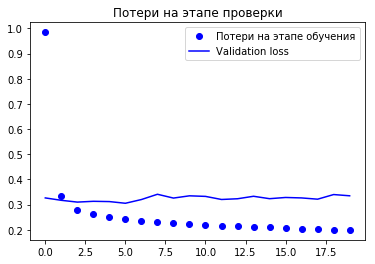

In [19]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Потери на этапе обучения')
plt.plot(epochs, val_loss, 'b', label='Потери на этапе проверки')
plt.title('''Потери на этапах обучения и проверки модели на основе полносвязной сети в задаче
прогнозирования температуры по данным Jena
''')
plt.legend()

plt.show()

Некоторые значения потерь на этапе проверки близки к оценке ошибки базового решения без привлечения машинного обучения, но эта связь ненадежна. Это
лишний раз показывает, как важно иметь базовое решение: в данном случае, как
оказалось, его нелегко превзойти. Наше базовое решение основано на ценной информации, к которой нет доступа у модели машинного обучения.
Возможно, у вас появился вопрос: коль скоро существует хорошая и простая модель прогнозирования целей по имеющимся данным (базовое решение), почему
обучаемая модель не смогла показать лучшие результаты? Потому что это простое
решение совсем не то, что пытается найти обучаемая модель. Пространство моделей, в котором мы ищем решение, то есть пространство гипотез, — это пространство
всех возможных двухслойных сетей с определяемой нами конфигурацией. Эти сети
уже довольно сложны. Когда поиск решения выполняется в пространстве сложных
моделей, простое базовое решение может оказаться ненадежным, даже если технически оно является частью пространства гипотез. Это существенное ограничение
машинного обучения в целом: если алгоритм обучения не запрограммирован на
поиск конкретной простой модели, обучение параметров иногда может терпеть
неудачу в попытках найти простое решение простой задачи.

## Первое базовое рекуррентное решение

Первое полносвязное решение не дало хорошего результата, но это не означает, что
машинное обучение неприменимо к данной задаче. В предыдущем подходе первым
действием было уменьшение размерности временных последовательностей, устранившее понятие времени из входных данных. Теперь посмотрим на эти данные как
на то, чем они являются в действительности: последовательность, в которой важны
причина и следствие. Попробуем использовать рекуррентную модель обработки
последовательностей — она должна идеально подходить для таких последовательностей данных как раз потому, что, в отличие от первого решения, учитывает упорядочение образцов во времени.
Вместо слоя LSTM, представленного в предыдущем разделе, используем слой GRU,
разработанный Чангом (Chung) с коллегами в 2014-м. Слои управляемых рекуррентных блоков (Gated Recurrent Unit, GRU) основаны на том же принципе, что
и слои LSTM, однако они представляют собой более простые структуры и, сооветственно, менее затратны в вычислительном смысле (хотя могут не иметь такой же репрезентативной мощности, как LSTM). Этот компромисс между затратностью вычислений и репрезентативной мощностью можно наблюдать повсюду в области
машинного обучения.

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 94s 188ms/step - loss: 0.3047 - val_loss: 0.2716
Epoch 2/20
500/500 [==============================] - 94s 187ms/step - loss: 0.2858 - val_loss: 0.2693
Epoch 3/20
500/500 [==============================] - 94s 187ms/step - loss: 0.2782 - val_loss: 0.2631
Epoch 4/20
500/500 [==============================] - 94s 187ms/step - loss: 0.2738 - val_loss: 0.2677
Epoch 5/20
500/500 [==============================] - 94s 187ms/step - loss: 0.2688 - val_loss: 0.2664
Epoch 6/20
500/500 [==============================] - 94s 187ms/step - loss: 0.2630 - val_loss: 0.2649
Epoch 7/20
500/500 [==============================] - 94s 188ms/step - loss: 0.2566 - val_loss: 0.2622
Epoch 8/20
500/500 [==============================] - 94s 188ms/step - loss: 0.2526 - val_loss: 0.2698
Epoch 9/20
500/500 [==============================] - 94s 187ms/step - loss: 0.2471 - val_loss: 0.2707
Epoch 10/20
500/500 [==============================] - 94s 187ms/step - l

Результаты показаны ниже:

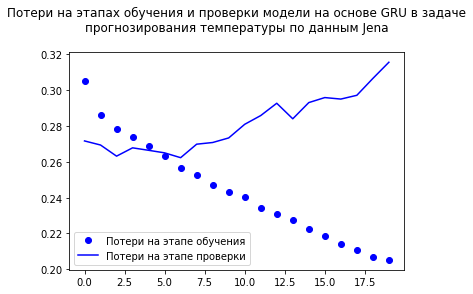

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Потери на этапе обучения')
plt.plot(epochs, val_loss, 'b', label='Потери на этапе проверки')
plt.title('''Потери на этапах обучения и проверки модели на основе GRU в задаче
прогнозирования температуры по данным Jena
''')
plt.legend()

plt.show()

Они оказались намного лучше! Нам удалось
значительно превзойти базовое решение и показать ценность машинного обучения,
а также превосходство рекуррентных сетей над последовательными полносвязными сетями для решения подобных задач.
Новая оценка MAE ~0,265 (полученная до значительного проявления эффекта
переобучения) после денормализации соответствует абсолютной ошибке 2,35 °C.
Это значительное улучшение относительно предыдущей ошибки 2,57 °C, но у нас,
возможно, еще есть потенциал для улучшения.


## Использование рекуррентного прореживания для борьбы с переобучением

Из кривых потерь на этапах обучения и проверки видно, что в модели быстро наступает эффект переобучения: потери начинают значительно отличаться уже после нескольких эпох. Вы уже знакомы с классическим приемом противостояния этому
явлению — прореживанием, когда обнуляются случайно выбранные входные значения, чтобы разрушить неожиданные корреляции в обучающих данных, влияющих на слой. Однако правильное применение прореживания в рекуррентных сетях —
сложная задача. Давно известно, что применение прореживания перед рекуррентным слоем скорее мешает обучению, а не помогает регуляризации. В 2015 году Ярин Гал (Yarin Gal), в рамках своей докторской диссертации по байесовскому
глубокому обучению, определил правильный способ применения прореживания к рекуррентным сетям: ко всем временным интервалам должна применяться одна и та же маска прореживания (должны обнуляться одни и те же значения) и не из-
меняться от интервала к интервалу. Более того, для регуляризации представлений, сформированных рекуррентными слоями, такими как GRU и LSTM, временно-постоянная маска прореживания должна применяться к внутренним рекуррентным
активациям слоя (рекуррентная маска прореживания). Применение той же маски прореживания к каждому интервалу времени позволяет сети правильно распро странить свою ошибку обучения во времени; напротив временно-случайная маска нарушит
этот сигнал ошибки и навредит процессу обучения.


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 105s 210ms/step - loss: 0.3460 - val_loss: 0.2798
Epoch 2/40
500/500 [==============================] - 105s 209ms/step - loss: 0.3155 - val_loss: 0.2742
Epoch 3/40
500/500 [==============================] - 105s 209ms/step - loss: 0.3081 - val_loss: 0.2689
Epoch 4/40
500/500 [==============================] - 105s 209ms/step - loss: 0.3042 - val_loss: 0.2696
Epoch 5/40
500/500 [==============================] - 105s 210ms/step - loss: 0.3018 - val_loss: 0.2665
Epoch 6/40
500/500 [==============================] - 105s 209ms/step - loss: 0.2959 - val_loss: 0.2682
Epoch 7/40
500/500 [==============================] - 105s 209ms/step - loss: 0.2945 - val_loss: 0.2714
Epoch 8/40
500/500 [==============================] - 105s 209ms/step - loss: 0.2943 - val_loss: 0.2663
Epoch 9/40
500/500 [==============================] - 105s 209ms/step - loss: 0.2930 - val_loss: 0.2694
Epoch 10/40
500/500 [==============================] - 105s 209m

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Потери на этапе обучения')
plt.plot(epochs, val_loss, 'b', label='Потери на этапе проверки')
plt.title('''Потери на этапах обучения и проверки модели на основе GRU
с прореживанием в задаче прогнозирования температуры по данным Jena
''')
plt.legend()
plt.show()

Успех! Теперь эффект переобучения не наблюдается на протяжении первых 30 эпох. Однако хотя теперь оценки получились более стабильные, лучшие из них не намного ниже предыдущих.

## Наложение нескольких рекуррентных слоев друг на друга
Избавившись от эффекта переобучения, мы столкнулись с проблемой низкого
качества, поэтому теперь нужно подумать об увеличении емкости сети. Вспомните
описание обобщенного процесса машинного обучения: рекомендуется всегда стараться увеличивать емкость сети, пока на первое место не выйдет проблема переобучения (при условии, что предприняты все основные меры против нее, такие как
прореживание). Пока проблема переобучения не стоит остро, вероятно, сеть имеет
недостаточную емкость.
Увеличение емкости сети обычно осуществляется за счет увеличения числа параметров слоя или добавления дополнительных слоев. Наложение рекуррентных слоев
друг на друга — классический способ конструирования более мощных рекуррентных сетей: например, в настоящее время алгоритм Google Translate представляет собой стек из семи больших слоев LSTM — это огромная сеть.
При наложении друг на друга рекуррентных слоев в Keras все промежуточные
слои должны возвращать полные выходные последовательности (трехмерный
тензор), а не только последний интервал. Это достигается установкой параметра
`return_sequences=True`.


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 213s 426ms/step - loss: 0.3351 - val_loss: 0.2765
Epoch 2/40
500/500 [==============================] - 212s 424ms/step - loss: 0.3117 - val_loss: 0.2726
Epoch 3/40
500/500 [==============================] - 212s 424ms/step - loss: 0.3068 - val_loss: 0.2709
Epoch 4/40
500/500 [==============================] - 212s 424ms/step - loss: 0.3015 - val_loss: 0.2701
Epoch 5/40
500/500 [==============================] - 212s 424ms/step - loss: 0.2985 - val_loss: 0.2709
Epoch 6/40
500/500 [==============================] - 212s 423ms/step - loss: 0.2963 - val_loss: 0.2647
Epoch 7/40
500/500 [==============================] - 212s 424ms/step - loss: 0.2930 - val_loss: 0.2667
Epoch 8/40
500/500 [==============================] - 212s 424ms/step - loss: 0.2913 - val_loss: 0.2666
Epoch 9/40
500/500 [==============================] - 212s 424ms/step - loss: 0.2889 - val_loss: 0.2682
Epoch 10/40
500/500 [==============================] - 212s 424m

Результаты показаны ниже:

In [1]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Потери на этапе обучения')
plt.plot(epochs, val_loss, 'b', label='Потери на этапе проверки')
plt.title('''Потери на этапах обучения и проверки многослойной модели
на основе GRU в задаче прогнозирования температуры по данным Jena''')
plt.legend()

plt.show()

NameError: name 'history' is not defined

Отсюда можно сделать два вывода:   
* Поскольку проблема переобучения все еще не стоит остро, можно продолжить
увеличивать размеры слоев в попытках улучшить оценку потерь на этапе
проверки. Однако это сопряжено с немалыми затратами вычислительных
ресурсов.
* Добавление слоя не привело к существенному улучшению, то есть в данном
случае наблюдается уменьшение отдачи от увеличения емкости сети.


## Задания

Существует множество других приемов, которые можно было бы попробовать применить, чтобы улучшить качество прогнозирования температуры:
* Изменить количество параметров в каждом рекуррентном слое в конфигурации
с несколькими слоями. Текущий выбор был сделан практически произвольно
и поэтому наверняка не является оптимальным.
* Изменить скорость обучения с помощью оптимизатора RMSprop .
* Попробовать использовать слои LSTM вместо GRU .
* Попробовать использовать больший полносвязный регрессор поверх рекуррентных слоев, то есть больший слой Dense или даже несколько слоев Dense.
* Не забудьте, наконец, опробовать лучшие модели (с точки зрения средней
абсолютной ошибки) на контрольном наборе! Иначе у вас будут получаться
архитектуры, переобученные на проверочном наборе.

## Выводы

Вот какие выводы вы должны сделать из всего, что узнали:
* Как мы впервые узнали в лекции 4, приступая к решению новой задачи, всегда
желательно получить базовое решение, опираясь на метрики по вашему выбору.
Если у вас не будет такого базового решения, на которое можно ориентироваться, вы не сможете сказать, движетесь ли вы в правильном направлении.
* Пробуйте сначала создавать простые модели, чтобы убедиться в необходимости
приложения дополнительных усилий. Иногда простая модель может оказаться
лучшим решением.
* Для обработки данных, в которых порядок следования имеет значение, лучше
всего подходят рекуррентные сети — они с легкостью превосходят модели, которые сначала снижают размерность исходных данных.
* Применяя прием прореживания с рекуррентными сетями, использyйте временно-постоянные и рекуррентные маски прореживания. В Keras уже имеются
встроенные рекуррентные слои, поэтому вам останется только определить их аргументы dropout и  recurrent_dropout .
* Комбинации из нескольких рекуррентных слоев обеспечивают большую репрезентативность, чем один слой. Они также являются намного более затратными
с точки зрения вычислений, и поэтому их применение не всегда оправданно.
Они позволяют повысить качество решения сложных задач (таких, как машинный перевод), но не всегда подходят для небольших и простых задач.
* Двунаправленные рекуррентные сети, просматривающие последовательность данных в обоих направлениях, дают хорошие результаты в задачах обработки естественного языка. Но они мало пригодны для обработки последовательностей, в которых недавние данные информативнее, чем находящиеся
в начале.